In [77]:
import torch.nn as nn
import numpy as np
import torch
from tqdm import trange
import matplotlib.pyplot as plt
import torchvision
%matplotlib inline

In [2]:
# load the MNIST DATASET
training_data = torchvision.datasets.MNIST(root="mnist_data",train=True,download=True,transform=torchvision.transforms.ToTensor())
testing_data = torchvision.datasets.MNIST(root="mnist_data",train=False,download=True,transform=torchvision.transforms.ToTensor())

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
# Reshaping the tensors
x_train,y_train = training_data.data.reshape(-1,28*28).double(),training_data.targets
x_test,y_test = testing_data.data.reshape(-1,28*28).double(),testing_data.targets

In [5]:
# Model
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(784,128)
        self.l2 = nn.Linear(128,10)
        self.act = nn.ReLU()
    
    def forward(self,x):
        x = self.act(self.l1(x))
        x = self.l2(x)
        return x

model = Net().double()

In [6]:
# Training
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),momentum=0.3)
BS = 32
for _ in (t:= trange(5000,colour="green")):
     samp = torch.randint(0,x_train.shape[0],(BS,))
     optimizer.zero_grad()
     loss = loss_fn(model(x_train[samp]),y_train[samp])
     loss.backward()
     optimizer.step()
     out = model(x_train[samp]).softmax(dim=1)
     accuracy = (torch.argmax(out,dim=1) == y_train[samp]).double().mean()
     t.set_description(f"Loss = {loss:0.5f} Accuracy {accuracy.item():0.2f}")

Loss = 0.34778 Accuracy 0.97: 100%|██████████| 5000/5000 [00:06<00:00, 762.67it/s]


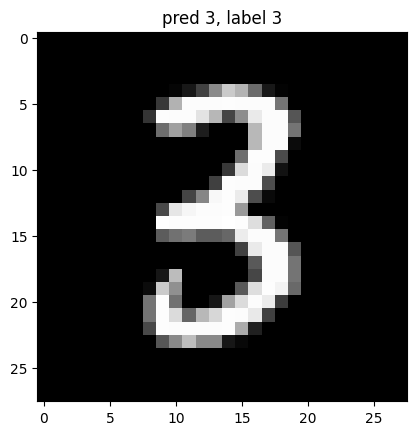

In [7]:
# Visualize
n = torch.randint(0, x_test.shape[0],(1,))
plt.title(f"pred {torch.argmax(model(x_test[n].reshape(1,-1)).softmax(dim=1),dim=1).item()}, label {y_test[n].item()}")
plt.imshow(x_test[n].reshape(28, 28),cmap="gray")

In [8]:
# Evaluation on the test dataset
out = model(x_test).softmax(dim=1)
accuracy = (torch.argmax(out,dim=1) == y_test).double().mean().item()
print(f"{accuracy * 100:0.2f}")

95.36


Forward pass using numpy

In [82]:
np.set_printoptions(precision=4)

In [83]:
x = x_train.numpy()
y = y_train.numpy()

In [84]:
# softmax activation function
def softmax(x):
    exp_sum = np.sum(np.exp(x), axis=1,keepdims=True)
    return np.exp(x) / exp_sum


# Cross Entropy loss
def crossentropyloss(x, y):
    x = softmax(x)
    loss = -np.log(x[range(len(y)), y])
    return loss.mean()

In [85]:
w1 = model.l1.weight.detach().numpy().T
w2 = model.l2.weight.detach().numpy().T
b1 = model.l1.bias.detach().numpy().reshape(1,-1)
b2 = model.l2.bias.detach().numpy().reshape(1,-1)


In [98]:
relu = lambda x: np.maximum(x, 0)
# Forward pass
def forward(x):
    x = x @ w1 + b1
    x = relu(x)
    x = x @ w2 + b2
    return x

In [105]:
softmax(forward(x[0]))

array([[3.5260e-13, 1.1033e-07, 9.2237e-10, 8.5194e-03, 5.9984e-13,
        9.9147e-01, 1.4511e-12, 1.4556e-06, 3.9105e-08, 1.2039e-05]])

In [106]:
model(x_train)[:1].softmax(dim=1)

tensor([[3.5260e-13, 1.1033e-07, 9.2237e-10, 8.5194e-03, 5.9984e-13, 9.9147e-01,
         1.4511e-12, 1.4556e-06, 3.9105e-08, 1.2039e-05]], dtype=torch.float64,
       grad_fn=<SoftmaxBackward0>)

In [101]:
crossentropyloss(forward(x),y)

0.10457354194643209

In [102]:
# Torch loss function 
nn.functional.cross_entropy(model(x_train),y_train).item()

0.1045735419464321